<a href="https://colab.research.google.com/github/sanjuth/dlvs/blob/main/lungs_ct_scan_semantic_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Implement a model to mask various categories with Semantic Segmentation


**Dataset link -** https://www.kaggle.com/kmader/finding-lungs-in-ct-data

**About the dataset:**
- This dataset is a collection of 2D images with manually segmented lungs.
- Using semantic segmentation we will try to find lesions in CT images of the lungs.

## Load all required libraries

In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

#for building and training the U-Net model
from tensorflow.keras.layers import Conv2D, Input, Concatenate, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model

print("Loaded all libraries")

Loaded all libraries


## Data loading and data exploration

In [ ]:
train_fpath='../input/finding-lungs-in-ct-data/2d_images/'
train_masks_fpath='../input/finding-lungs-in-ct-data/2d_masks/'

#test_fpath='../input/3d_images/'
#test_masks_fpath='../input/3d_masks/'
print(os.listdir('../input/finding-lungs-in-ct-data/2d_images/'))

['ID_0055_Z_0122.tif', 'ID_0144_Z_0224.tif', 'ID_0111_Z_0078.tif', 'ID_0041_Z_0336.tif', 'ID_0052_Z_0108.tif', 'ID_0026_Z_0140.tif', 'ID_0074_Z_0066.tif', 'ID_0212_Z_0064.tif', 'ID_0124_Z_0066.tif', 'ID_0208_Z_0063.tif', 'ID_0258_Z_0072.tif', 'ID_0192_Z_0064.tif', 'ID_0031_Z_0232.tif', 'ID_0084_Z_0218.tif', 'ID_0157_Z_0070.tif', 'ID_0146_Z_0122.tif', 'ID_0196_Z_0259.tif', 'ID_0180_Z_0086.tif', 'ID_0099_Z_0069.tif', 'ID_0239_Z_0365.tif', 'ID_0079_Z_0072.tif', 'ID_0106_Z_0130.tif', 'ID_0161_Z_0075.tif', 'ID_0186_Z_0102.tif', 'ID_0102_Z_0238.tif', 'ID_0011_Z_0156.tif', 'ID_0253_Z_0238.tif', 'ID_0201_Z_0241.tif', 'ID_0047_Z_0272.tif', 'ID_0068_Z_0055.tif', 'ID_0158_Z_0164.tif', 'ID_0023_Z_0241.tif', 'ID_0252_Z_0064.tif', 'ID_0020_Z_0070.tif', 'ID_0206_Z_0062.tif', 'ID_0135_Z_0066.tif', 'ID_0122_Z_0066.tif', 'ID_0231_Z_0140.tif', 'ID_0211_Z_0140.tif', 'ID_0095_Z_0097.tif', 'ID_0117_Z_0235.tif', 'ID_0246_Z_0228.tif', 'ID_0081_Z_0066.tif', 'ID_0250_Z_0070.tif', 'ID_0210_Z_0140.tif', 'ID_0018_

In [ ]:
print("No. of images =",len(os.listdir(train_fpath)))
print("No. of image masks =",len(os.listdir(train_masks_fpath)))

No. of images = 267
No. of image masks = 267


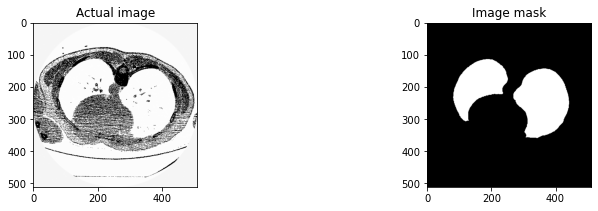

In [ ]:
#1 example let's pick image id 'ID_0066_Z_0141'
def plot_img_and_mask(id):
    img = cv2.imread(train_fpath + id + '.tif')
    img_mask = cv2.imread(train_masks_fpath + id + '.tif')
    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1,title='Actual image')
    plt.imshow(img)
    plt.subplot(1,3,3,title='Image mask')
    plt.imshow(img_mask)
    
plot_img_and_mask('ID_0066_Z_0141')

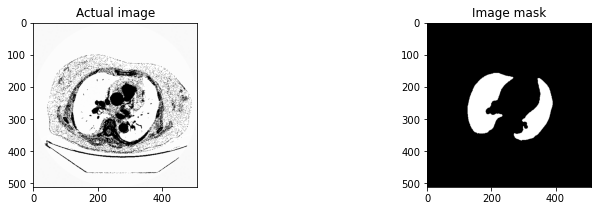

In [ ]:
plot_img_and_mask('ID_0202_Z_0098')

- Initialize training data

In [ ]:
def initialize_img_data(folder):
    lst=[] 
    for image in os.listdir(folder):
        #load image in grayscale
        img= cv2.imread(folder+"/"+image, cv2.IMREAD_GRAYSCALE)
        #convert to array
        img_array=Image.fromarray(img)
        #resize image
        resize_img = img_array.resize((128 , 128))
        #divide by 255 -> scaling data
        norm_img=np.array(resize_img)/255
        #expand dimensions
        img_array = norm_img.reshape((128,128,1))#np.expand_dims(norm_img,axis=3)
        
        lst.append(img_array)
    return lst
    
X = initialize_img_data(train_fpath)
y = initialize_img_data(train_masks_fpath)


In [ ]:
#quick verification whether all the data is initialized or not
print(len(os.listdir(train_fpath)),len(X),len(y))
print(X[0].shape,y[0].shape)

267 267 267
(128, 128, 1) (128, 128, 1)


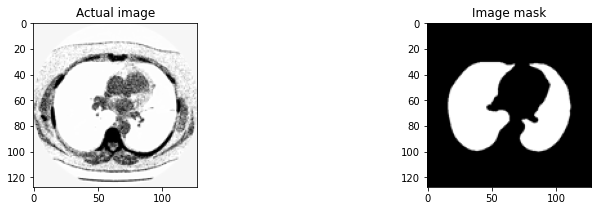

In [ ]:
#check data once they are loaded
plt.figure(figsize=(10,10))
plt.subplot(1,3,1,title='Actual image')
plt.imshow(X[10],cmap="gray")

plt.subplot(1,3,3,title='Image mask')
plt.imshow(y[10],cmap="gray")

In [ ]:
X = np.array(X)
y = np.array(y)

- Split dataset into train, test sets

In [ ]:
x_train = X[:200]
y_train = y[:200]

x_test = X[200:]
y_test = y[200:]

## Build U-Net model

In [ ]:
# Build U-Net model - Define layers
inputs = Input(shape=(128, 128, 1))

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (inputs)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = Concatenate()([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = Concatenate()([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = Concatenate()([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = Concatenate()([u9, c1]) #removed ,axis=3
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

- Initialize the model

In [ ]:
model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 8)  80          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 8)  584         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 8)    0           conv2d_1[0][0]                   
______________________________________________________________________________________________

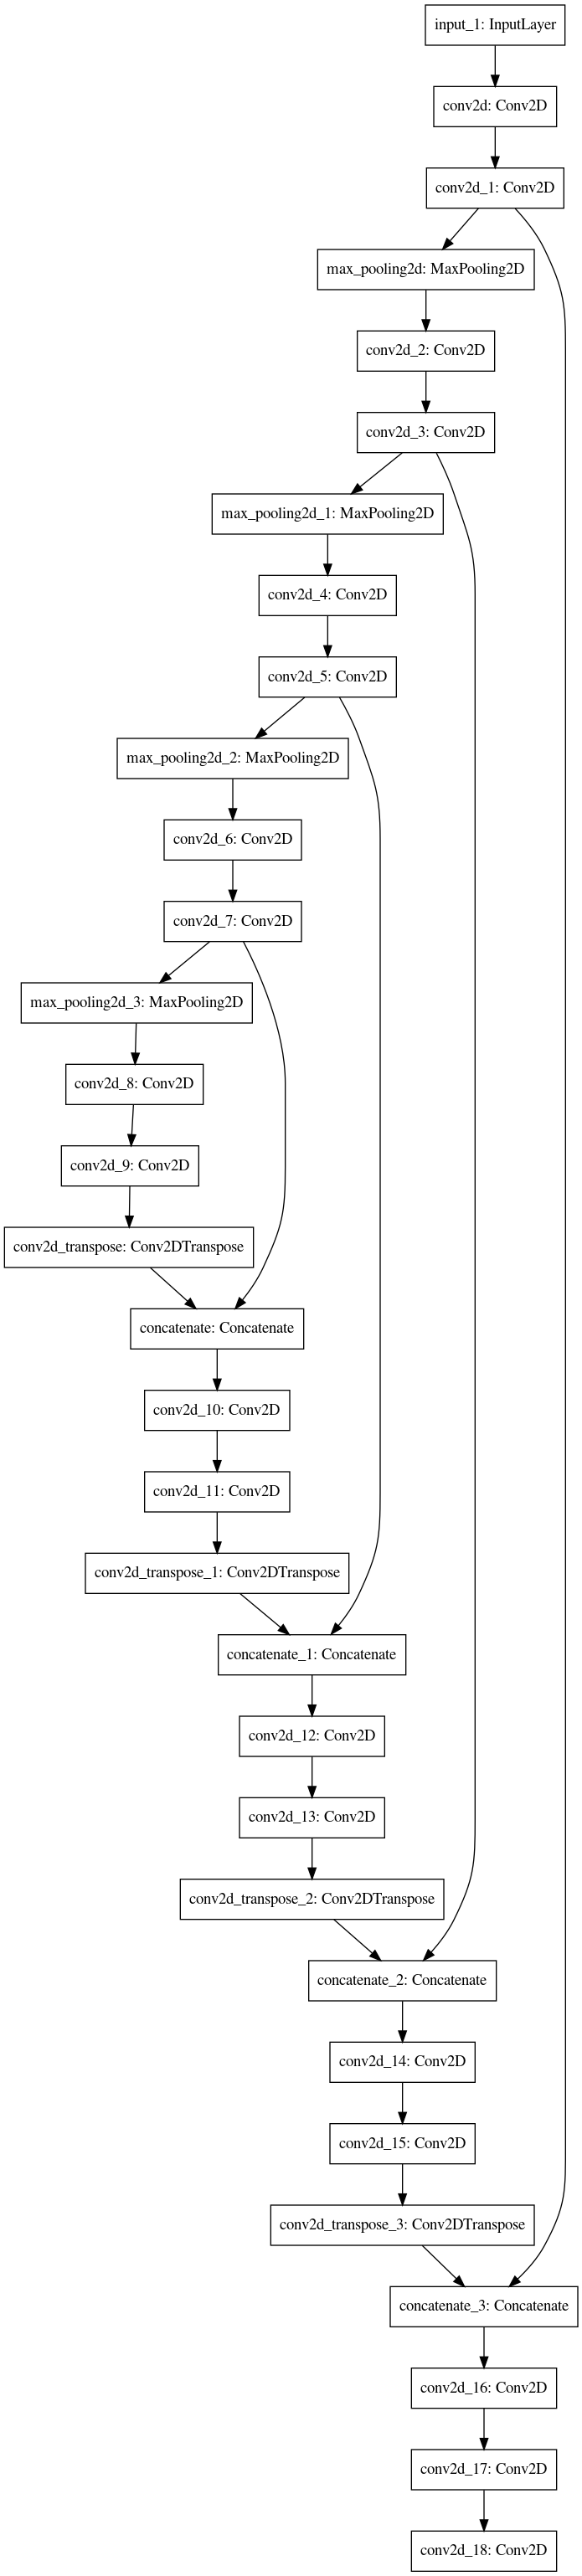

In [ ]:
from keras.utils import plot_model
plot_model(model,to_file='model.png')

- Fit the model

In [ ]:
x_train.shape

(200, 128, 128, 1)

In [ ]:
early_stop = EarlyStopping(patience=5)
check_point = ModelCheckpoint('model.hdf5',save_best_only=True)
model.fit(x_train, y_train, epochs=200, callbacks=[early_stop,check_point])

Epoch 1/200
7/7 [==============================] - 5s 57ms/step - loss: 0.6639
Epoch 2/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6052
Epoch 3/200
7/7 [==============================] - 0s 21ms/step - loss: 0.5901
Epoch 4/200
7/7 [==============================] - 0s 21ms/step - loss: 0.5649
Epoch 5/200
7/7 [==============================] - 0s 21ms/step - loss: 0.5181
Epoch 6/200
7/7 [==============================] - 0s 21ms/step - loss: 0.4909
Epoch 7/200
7/7 [==============================] - 0s 21ms/step - loss: 0.4637
Epoch 8/200
7/7 [==============================] - 0s 21ms/step - loss: 0.3969
Epoch 9/200
7/7 [==============================] - 0s 21ms/step - loss: 0.3679
Epoch 10/200
7/7 [==============================] - 0s 21ms/step - loss: 0.3562
Epoch 11/200
7/7 [==============================] - 0s 21ms/step - loss: 0.3630
Epoch 12/200
7/7 [==============================] - 0s 21ms/step - loss: 0.3368
Epoch 13/200
7/7 [==============================]

In [ ]:
pred_test = model.predict(x_test, verbose=1)

3/3 [==============================] - 0s 46ms/step


In [ ]:
#exclude channels axis
x_test = np.squeeze(x_test,axis=-1)
pred_test = np.squeeze(pred_test,axis=-1)

print(x_test.shape, pred_test.shape)

(67, 128, 128) (67, 128, 128)


- Check the predicted outputs

Predicted masks on test images

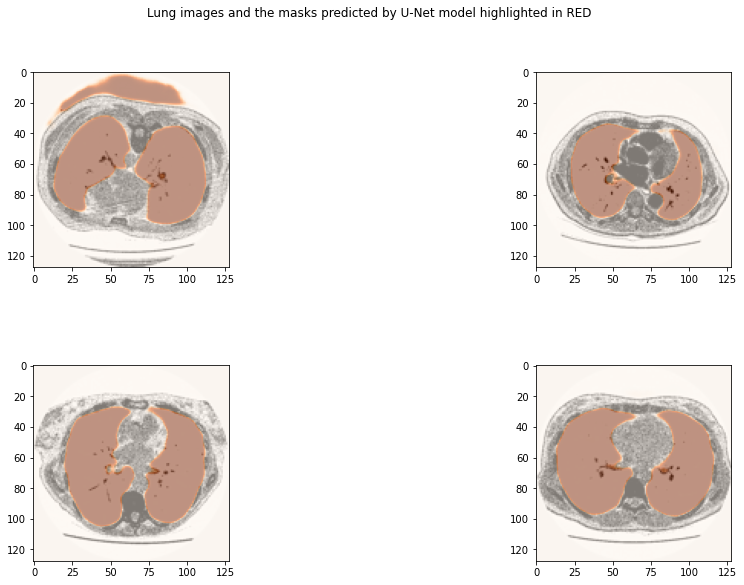

In [ ]:
plt.figure(1 , figsize = (15, 9))
n = 0 
for i in range(4):
    n += 1 
    #r = np.random.randint(0, x_test.shape[0], 1)
    r=[i]
    plt.subplot(2, 2, n)
    plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
    plt.imshow(x_test[r[0]], cmap="gray")
    plt.imshow(pred_test[r[0]], alpha=0.5, cmap="Oranges")
    

plt.suptitle("Lung images and the masks predicted by U-Net model highlighted in RED")
plt.show()

Actual masks on test images

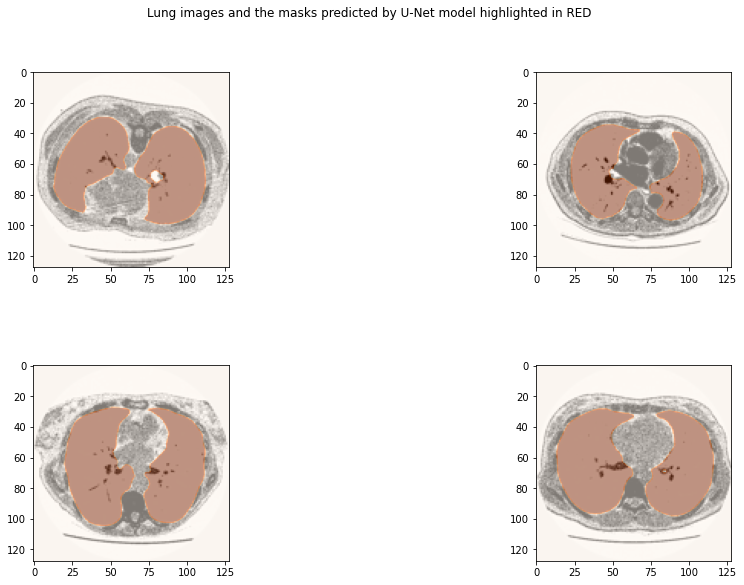

In [ ]:
plt.figure(1 , figsize = (15, 9))
n = 0 
for i in range(4):
    n += 1 
    #r = np.random.randint(0, x_test.shape[0], 1)
    r=[i]
    plt.subplot(2, 2, n)
    plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
    plt.imshow(x_test[r[0]], cmap="gray")
    plt.imshow(y_test[r[0]], alpha=0.5, cmap="Oranges")
    

plt.suptitle("Lung images and the masks predicted by U-Net model highlighted in RED")
plt.show()